In [2]:
# Set the working directory to ../
import os
os.chdir("../")

In [20]:
from tripsender import od
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

list_of_functions=[
#'Komplementbyggnad; Ospecificerad',
#'Bostad; Småhus friliggande',
#'Övrig byggnad; Ospecificerad',
'Samhällsfunktion; Reningsverk',
#'Bostad; Småhus med flera lägenheter',
'Samhällsfunktion; Distributionsbyggnad',
'Industri; Övrig industribyggnad',
'Industri; Annan tillverkningsindustri',
#'Bostad; Småhus kedjehus',
#'Samhällsfunktion; Ospecificerad',
#'Bostad; Flerfamiljshus',
'Samhällsfunktion; Samfund',
#'Verksamhet; Ospecificerad',
#'Bostad; Småhus radhus',
'Ekonomibyggnad; Ospecificerad',
'Samhällsfunktion; Skola',
#'Industri; Ospecificerad',
'Industri; Industrihotell',
'Samhällsfunktion; Djursjukhus',
'Samhällsfunktion; Sporthall',
'Industri; Trävaruindustri',
#'Samhällsfunktion; Kulturbyggnad',
'Samhällsfunktion; Brandstation',
'Samhällsfunktion; Försvarsbyggnad',
'Samhällsfunktion; Hälsocentral',
'Industri; Kemisk industri',
'Industri; Vattenkraftverk',
#'Bostad; Ospecificerad',
'Industri; Metall- eller maskinindustri',
'Samhällsfunktion; Kommunhus',
#'Samhällsfunktion; Badhus',
#'Samhällsfunktion; Ishall',
'Samhällsfunktion; Ridhus',
'Industri; Textilindustri',
'Industri; Livsmedelsindustri',
'Samhällsfunktion; Kriminalvårdsanstalt',
'Samhällsfunktion; Sjukhus',
'Samhällsfunktion; Polisstation',
'Industri; Värmeverk',
'Samhällsfunktion; Vattenverk',
#'Samhällsfunktion; Multiarena',
#'Samhällsfunktion; Busstation',
'Industri; Gasturbinanläggning',
'Samhällsfunktion; Universitet',
'Samhällsfunktion; Högskola',
'Samhällsfunktion; Järnvägsstation',
#'Industri; Vindkraftverk'
]


# Construct the SQL query
sql = "SELECT * FROM se_got_phy_buildingfootprint_lm"

# Fetch the data using the get_pg_query function
gdf = od.get_pg_query(sql, local=False, web=False)

# Filter based on functions in the list and select necessary columns
gdf = gdf[gdf['andamal_1t'].isin(list_of_functions)][["geom", "andamal_1t", "height"]]

# Rename columns and set the geometry
gdf.rename(columns={"geom": "geometry"}, inplace=True)
gdf.set_geometry("geometry", inplace=True)

# Compute floors, footprint area, and filter buildings based on the area
gdf['floors'] = gdf['height'].round(0)
gdf['footprint_area'] = gdf['geometry'].area
gdf = gdf[gdf['footprint_area'] > 500]

# Compute BTA (total area)
gdf['BTA'] = gdf['footprint_area'] * gdf['floors']

# Compute jobs using the total workers value and jobs per m2
total_workers = 236037  # Förvärvsarbetande 16-74 år efter bostadens och arbetsställets GR-kommun, 2007-2021
jobs_per_m2 = total_workers / gdf['BTA'].sum()
gdf['jobs'] = gdf['BTA'] * jobs_per_m2

# Get centroid and prepare a new GDF for job locations
gdf['centroid'] = gdf['geometry'].centroid
gdf_jobs = gdf[['andamal_1t', 'jobs', 'centroid']].set_geometry('centroid')

# Save to file
gdf_jobs.to_file("data/processed/jobs.shp", driver='ESRI Shapefile')


In [22]:
from tripsender.location_assignment import compute_job_density

gdf_jobs_density = compute_job_density('data/processed/jobs.shp', 1000)

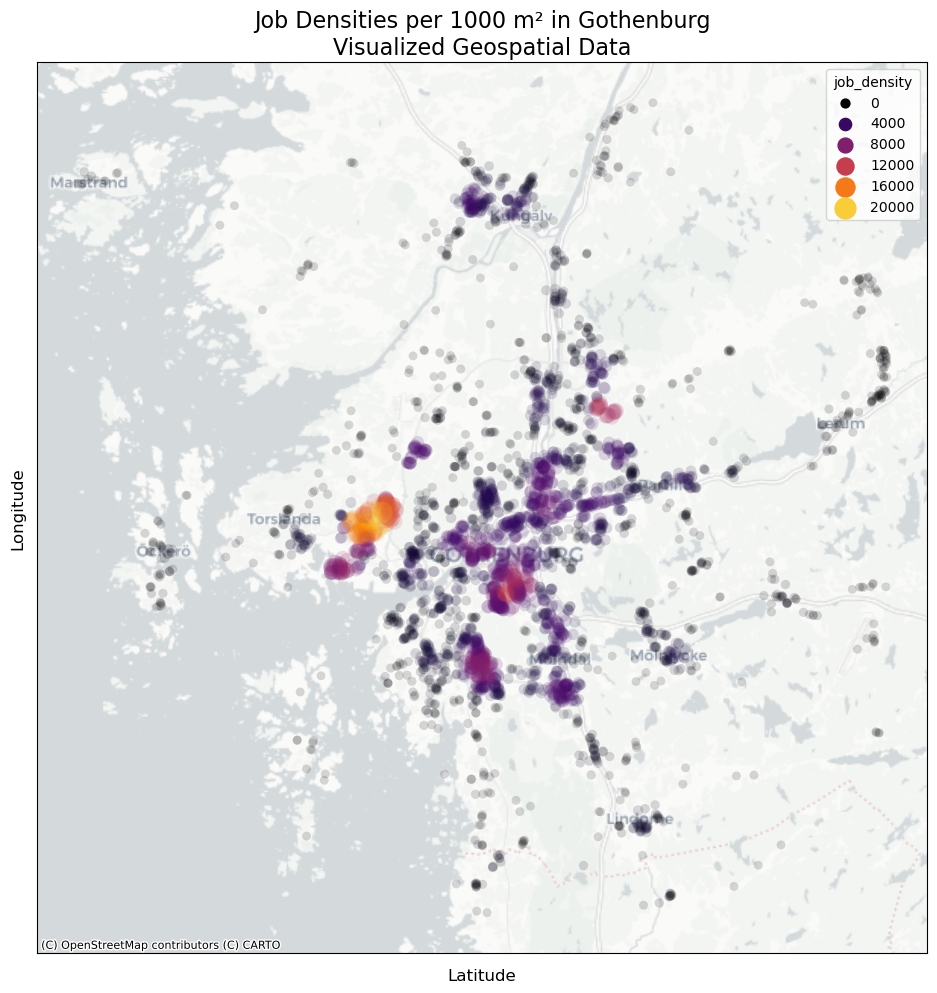

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

# Change from 3006 to 3857
gdf_jobs_density = gdf_jobs_density.to_crs(epsg=3857)

# Improved Plotting
fig, ax = plt.subplots(figsize=(12, 10))  # Adjusted figure size
sns.scatterplot(data=gdf_jobs_density, x=gdf_jobs_density['centroid'].x, y=gdf_jobs_density['centroid'].y, 
                hue='job_density', legend=True, palette='inferno',
                size='job_density', edgecolor='none', alpha=0.15, sizes=(40, 250))  # Adjusted alpha and sizes
ax.set_title('Job Densities per 1000 m² in Gothenburg\nVisualized Geospatial Data', fontsize=16)
ax.set_xticks([])  # Keeping axes clean
ax.set_yticks([])
ax.annotate('Latitude', (0.5, -0.03), xycoords='axes fraction', ha='center', fontsize=12)
ax.annotate('Longitude', (-0.03, 0.5), xycoords='axes fraction', va='center', rotation=90, fontsize=12)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()


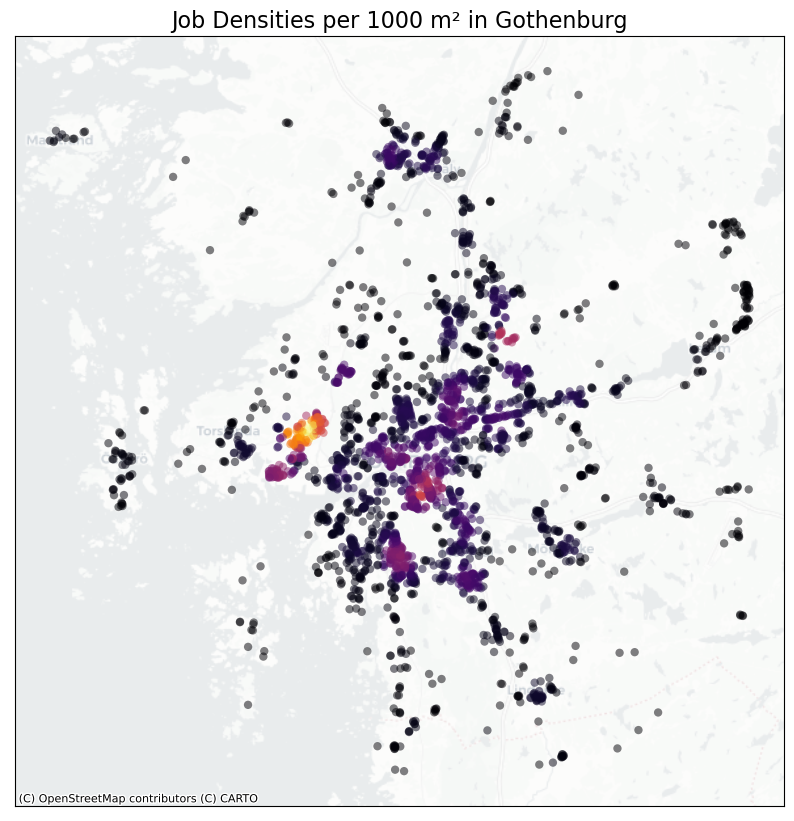

In [79]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

# Change from 3006 to 3857
gdf_jobs_density = gdf_jobs_density.to_crs(epsg=3857)

# Creating a heatmap-like plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_jobs_density.plot(column='job_density', cmap='inferno', linewidth=0, ax=ax, legend=False, alpha=0.5)
# Setting title and removing axes ticks and labels
ax.set_title('Job Densities per 1000 m² in Gothenburg', fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

# Adding a basemap for geographical context
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.5)

# Display the plot
plt.show()



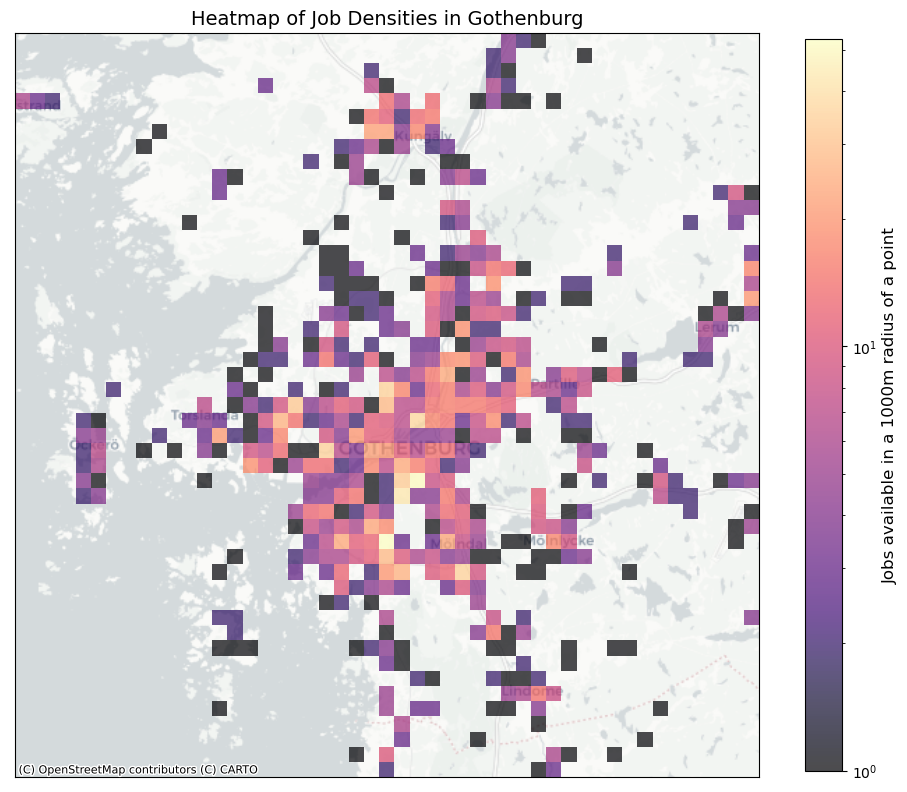

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import matplotlib.colors as colors

# Convert to Web Mercator (3857)
gdf_jobs_density = gdf_jobs_density.to_crs(epsg=3857)

# Extract x and y coordinates from centroids
x_coords = gdf_jobs_density['centroid'].x
y_coords = gdf_jobs_density['centroid'].y

# Define the number of bins along each axis
n_bins = 50  # Adjust based on your data density

# Create a 2D histogram grid
x_bins = np.linspace(x_coords.min(), x_coords.max(), n_bins)
y_bins = np.linspace(y_coords.min(), y_coords.max(), n_bins)
heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=[x_bins, y_bins])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Use pcolormesh with logarithmic color scaling
cmap = plt.get_cmap('magma')
norm = colors.LogNorm(vmin=heatmap[heatmap>0].min(), vmax=heatmap.max())
heatmap_plot = plt.pcolormesh(xedges, yedges, heatmap.T, cmap=cmap, norm=norm, alpha=0.7)

# Add colorbar
cbar = plt.colorbar(heatmap_plot, ax=ax, shrink=0.95)  # shrink parameter to adjust the size of the colorbar
cbar.set_label('Jobs available in a 1000m radius of a point', fontsize=12)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Remove axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])

# Adjust title
ax.set_title('Heatmap of Job Densities in Gothenburg', fontsize=14)

# Add a subtitle below the plot
#fig.text(0.5, 0.05, 'This heatmap visualises the distribution of job densities across Gothenburg, \nhighlighting areas with higher concentrations. \nJob density is calculated as the number of potential jobs\navailable in a 1000m radius of a building', ha='center', fontsize=10)

plt.show()
